In [5]:
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from torchvision.io.image import ImageReadMode
from torchvision.io import read_image
import torch.nn.functional as F

class DownscalingDataset(Dataset):
    def __init__(self, hr_dir, lr_dir,
                 transform_hr=None, transform_lr=None, max_len=1e6):
        print(hr_dir)
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.transform_hr = transform_hr
        self.transform_lr = transform_lr
        self.max_t = (len(os.listdir(self.hr_dir)) - 2) * 2
        self.max_len = max_len

    def __len__(self):
        return np.min([len(os.listdir(self.hr_dir)), self.max_len])

    def __getitem__(self, idx):
        if(idx * 4 > self.max_t):
            prefix = "va"
            t = (idx - 1)*4 - self.max_t
            filename = "{}_{}.png".format(prefix, t)
        else:
            prefix = "ua"
            t = idx * 4
            filename = "{}_{}.png".format(prefix, t)
        hr_path = os.path.join(self.hr_dir, filename)
        lr_path = os.path.join(self.lr_dir, filename)
        # mode ensures RGB values (i.e. only three channels, no alpha channel)
        image_hr = read_image(hr_path, mode = ImageReadMode(3)).float()
        image_lr = read_image(lr_path, mode = ImageReadMode(3)).float()
        if self.transform_hr:
            image_hr = self.transform_hr(image_hr)
        if self.transform_lr:
            image_lr = self.transform_hr(image_lr)
        return image_hr, image_lr
    


def get_data(args):
    if args.dataset_type == "temperature":
        dataset = DownscalingTemperatureDataset(args.dataset_path_hr, args.dataset_path_lr,
                                                max_len = args.dataset_size)
    elif args.dataset_type == "wind":
        dataset = DownscalingDataset(args.dataset_path_hr, args.dataset_path_lr,
                                     max_len = args.dataset_size)
    if args.repeat_observations > 1:
        dataset = Subset(dataset, np.tile(np.arange(len(dataset)), args.repeat_observations))

    dataloader = DataLoader(dataset, args.batch_size)
    return dataloader

In [7]:
import argparse
args = argparse.ArgumentParser()
args.parse_args("")
args.dataset_type = "wind"
args.image_size = 64
args.dataset_path_hr = "/scratch/users/mschillinger/Documents/DL-project/WiSoSuper/train/wind/middle_patch_subset/HR"
args.dataset_path_lr = "/scratch/users/mschillinger/Documents/DL-project/WiSoSuper/train/wind/middle_patch_subset/LR"
args.dataset_size = 1
args.repeat_observations = 10
args.batch_size = 1

/scratch/users/mschillinger/Documents/DL-project/WiSoSuper/train/wind/middle_patch_subset/HR
Train hr shape: torch.Size([1, 3, 64, 64])
Train lr shape: torch.Size([1, 3, 16, 16])


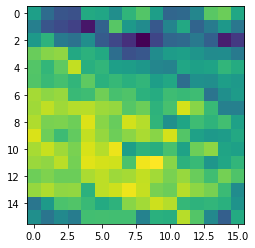

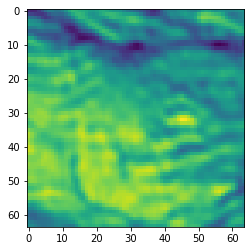

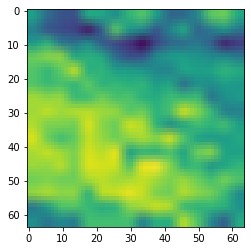

Train hr shape: torch.Size([1, 3, 64, 64])
Train lr shape: torch.Size([1, 3, 16, 16])


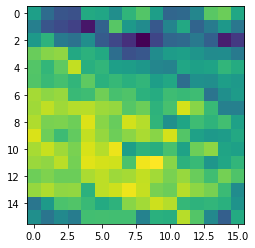

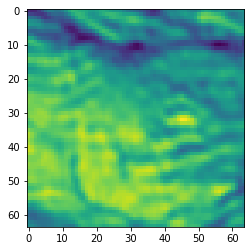

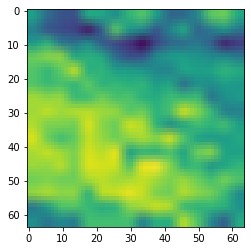

In [20]:
dataloader = get_data(args)
it = iter(dataloader)
for i in range(2):
    train_hr, train_lr = next(it)
    print(f"Train hr shape: {train_hr.size()}")
    print(f"Train lr shape: {train_lr.size()}")
    img = train_hr[0].unsqueeze(0).float()
    lr = train_lr[0].unsqueeze(0).float()
    y = F.interpolate(lr, size = [64,64], mode = 'bilinear')
    # y = F.interpolate(lr, size = [64, 64], mode = 'bicubic')
    img = img.squeeze().permute(1, 2, 0).byte()
    lr = lr.squeeze().permute(1, 2, 0).byte()
    y = y.squeeze().permute(1,2,0).byte()
    plt.imshow(lr)
    plt.show()
    plt.imshow(img)
    plt.show()
    plt.imshow(y)
    plt.show()

In [21]:
len(dataloader)

10

In [90]:
import torchvision.datasets
import torchvision.transforms as T

class DownscalingMNIST(datasets.MNIST):
    def __init__(self, path, max_len = 1e6, **kwargs):
        super().__init__(path, transform = T.ToTensor(),**kwargs)
        self.max_len = max_len

    def __len__(self):
        return np.min([super().__len__(), self.max_len])

    def __getitem__(self, idx):
        y, _ = super().__getitem__(idx)
        x = T.Resize((7, 7))(y)
        return y, x

In [107]:
import argparse
args = argparse.ArgumentParser()
args.parse_args("")
args.dataset_type = "wind"
args.image_size = 28
args.dataset_path = "/scratch/users/mschillinger/Documents/DL-project"
args.dataset_size = 100
args.repeat_observations = 10
args.batch_size = 1

In [108]:
# dataset = DownscalingMNIST(args.dataset_path, max_len = args.dataset_size)
dataset = datasets.MNIST(args.dataset_path, transform = T.ToTensor(), train = True)
dataloader = DataLoader(dataset, args.batch_size)

tensor([5])


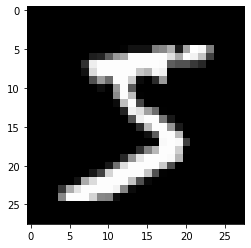

tensor([0])


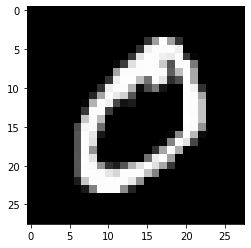

tensor([4])


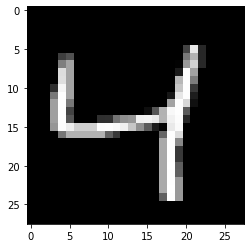

tensor([1])


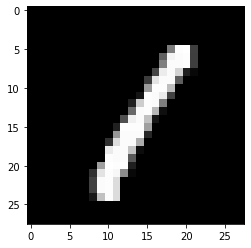

tensor([9])


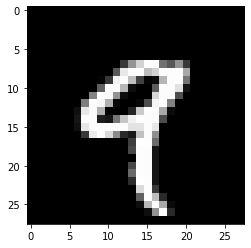

tensor([2])


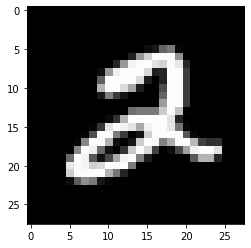

tensor([1])


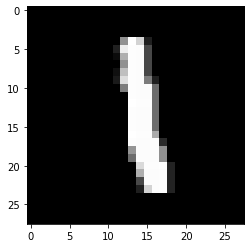

tensor([3])


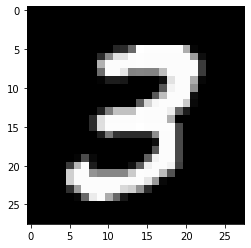

tensor([1])


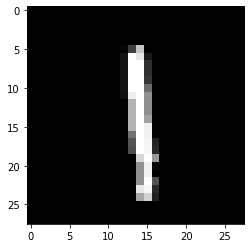

tensor([4])


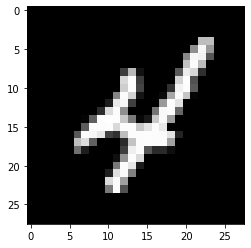

In [111]:
it = iter(dataloader)
for i in range(10):
    y, label = next(it)
    print(label)
    plt.imshow(y.squeeze(), cmap="gray")
    plt.show()


In [112]:
dataset = DownscalingMNIST(args.dataset_path, max_len = args.dataset_size)
dataloader = DataLoader(dataset, args.batch_size)

Train hr shape: torch.Size([1, 1, 28, 28])
Train lr shape: torch.Size([1, 1, 7, 7])


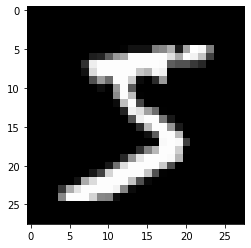

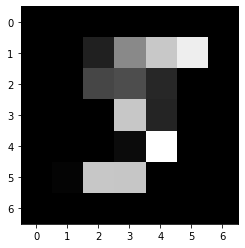

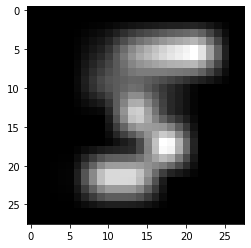

Train hr shape: torch.Size([1, 1, 28, 28])
Train lr shape: torch.Size([1, 1, 7, 7])


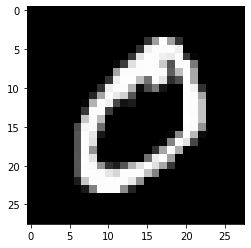

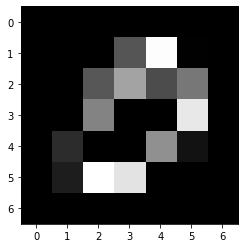

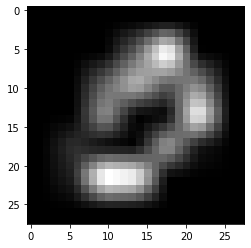

Train hr shape: torch.Size([1, 1, 28, 28])
Train lr shape: torch.Size([1, 1, 7, 7])


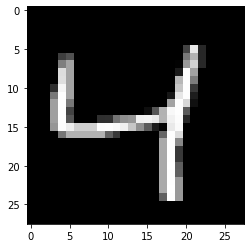

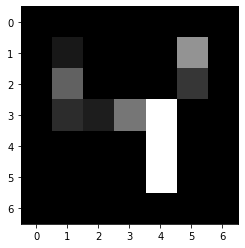

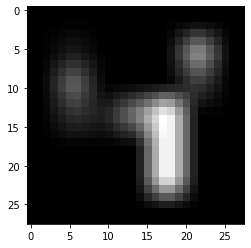

Train hr shape: torch.Size([1, 1, 28, 28])
Train lr shape: torch.Size([1, 1, 7, 7])


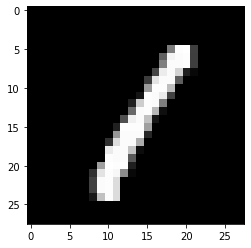

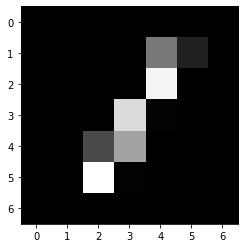

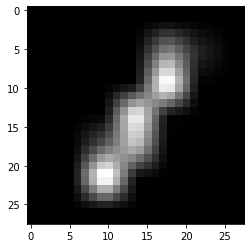

Train hr shape: torch.Size([1, 1, 28, 28])
Train lr shape: torch.Size([1, 1, 7, 7])


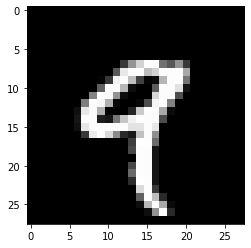

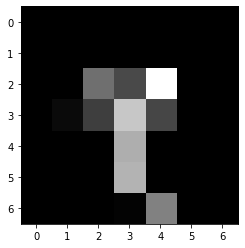

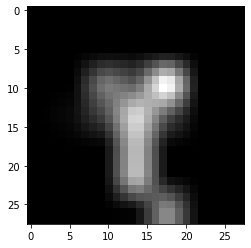

In [113]:
it = iter(dataloader)
for i in range(5):
    train_hr, train_lr = next(it)
    print(f"Train hr shape: {train_hr.size()}")
    print(f"Train lr shape: {train_lr.size()}")
    plt.imshow(train_hr.squeeze(), cmap = "gray")
    plt.show()
    plt.imshow(train_lr.squeeze(), cmap = "gray")
    plt.show()
    x = train_hr
    y = F.interpolate(train_lr.float(), size = [x.shape[-1], x.shape[-2]], mode = "bilinear")
    plt.imshow(y.squeeze(), cmap = "gray")
    plt.show()

In [50]:
img

tensor([[[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
  

In [38]:
y.shape

torch.Size([1, 1, 28, 28])

In [40]:
img.squeeze(0).shape

torch.Size([1, 28, 28])

In [75]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



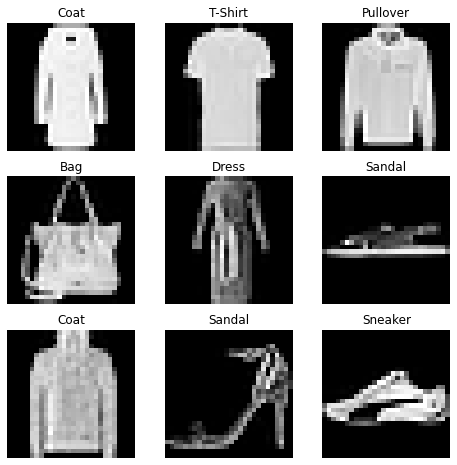

In [76]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [78]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.MNIST(
    root= "/scratch/users/mschillinger/Documents/DL-project",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root=  "/scratch/users/mschillinger/Documents/DL-project",
    train=False,
    download=True,
    transform=ToTensor()
)

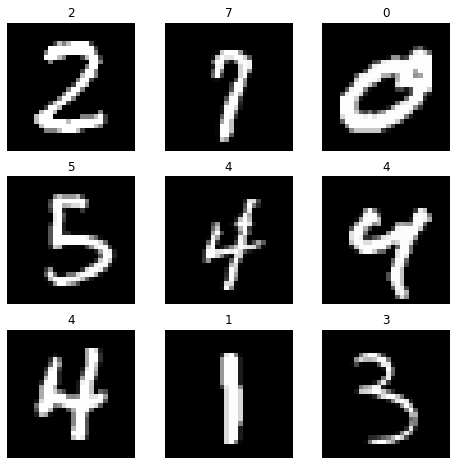

In [79]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [114]:


class Diffusion:
    def __init__(self, noise_steps=1000, noise_schedule = "linear", \
    beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule(type = noise_schedule).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self, type):
        if type == "linear":
            return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
        elif type == "cosine":
            # cosine schedule as proposed in https://arxiv.org/abs/2102.09672;
            # compare also https://huggingface.co/blog/annotated-diffusion for other schedules
            t = torch.linspace(0, self.noise_steps, self.noise_steps + 1)
            ft = torch.cos((t / self.noise_steps + 0.008) / 1.008 * np.pi / 2)**2
            alphat = ft / ft[0]
            betat = 1 - alphat[1:] / alphat[:-1]
            return torch.clip(betat, 0.0001, 0.9999)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        eps = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, images_lr, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            images_lr = images_lr.to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, images_lr)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [115]:
dataset = DownscalingMNIST(args.dataset_path, max_len = args.dataset_size)
dataloader = DataLoader(dataset, args.batch_size)

In [116]:
images_hr, images_lr = next(iter(dataloader))
sampled_images = diffusion.sample(model, n=len(images_lr), images_lr = images_lr)

NameError: name 'diffusion' is not defined